# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp6 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [11]:
count = 100 #number of returned tweets, default and max is 100
geocode = "31.8160381,-99.5120986,200mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [12]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Fri Dec 18 01:10:07 +0000 2020'
'Fri Dec 18 01:09:56 +0000 2020'
'Fri Dec 18 01:09:21 +0000 2020'
'Fri Dec 18 01:07:35 +0000 2020'
'Fri Dec 18 01:07:07 +0000 2020'
'Fri Dec 18 01:07:05 +0000 2020'
'Fri Dec 18 01:06:27 +0000 2020'
'Fri Dec 18 01:05:05 +0000 2020'
'Fri Dec 18 01:05:00 +0000 2020'
'Fri Dec 18 01:03:57 +0000 2020'
'Fri Dec 18 01:03:11 +0000 2020'
'Fri Dec 18 01:02:06 +0000 2020'
'Fri Dec 18 01:01:57 +0000 2020'
'Fri Dec 18 01:01:02 +0000 2020'
'Fri Dec 18 01:00:55 +0000 2020'
'Fri Dec 18 00:59:08 +0000 2020'
'Fri Dec 18 00:56:37 +0000 2020'
'Fri Dec 18 00:52:46 +0000 2020'
'Fri Dec 18 00:48:06 +0000 2020'
'Fri Dec 18 00:47:28 +0000 2020'
'Fri Dec 18 00:46:22 +0000 2020'
'Fri Dec 18 00:44:46 +0000 2020'
'Fri Dec 18 00:44:22 +0000 2020'
'Fri Dec 18 00:44:20 +0000 2020'
'Fri Dec 18 00:44:01 +0000 2020'
'Fri Dec 18 00:43:44 +0000 2020'
'Fri Dec 18 00:43:26 +0000 2020'
'Fri Dec 18 00:43:15 +0000 2020'
'Fri Dec 18 00:42:43 +0000 2020'
'Fri Dec 18 00:42:21 +0000 2020'
'Fri Dec 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [13]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Fri Dec 18 00:16:43 +0000 2020'
'Fri Dec 18 00:16:12 +0000 2020'
'Fri Dec 18 00:15:46 +0000 2020'
'Fri Dec 18 00:15:44 +0000 2020'
'Fri Dec 18 00:15:25 +0000 2020'
'Fri Dec 18 00:15:04 +0000 2020'
'Fri Dec 18 00:15:02 +0000 2020'
'Fri Dec 18 00:13:44 +0000 2020'
'Fri Dec 18 00:12:43 +0000 2020'
'Fri Dec 18 00:12:05 +0000 2020'
'Fri Dec 18 00:11:58 +0000 2020'
'Fri Dec 18 00:11:45 +0000 2020'
'Fri Dec 18 00:10:41 +0000 2020'
'Fri Dec 18 00:09:37 +0000 2020'
'Fri Dec 18 00:07:40 +0000 2020'
'Fri Dec 18 00:06:41 +0000 2020'
'Fri Dec 18 00:05:03 +0000 2020'
'Fri Dec 18 00:04:47 +0000 2020'
'Fri Dec 18 00:04:39 +0000 2020'
'Fri Dec 18 00:04:35 +0000 2020'
'Fri Dec 18 00:04:14 +0000 2020'
'Fri Dec 18 00:03:19 +0000 2020'
'Fri Dec 18 00:02:29 +0000 2020'
'Fri Dec 18 00:00:19 +0000 2020'
'Fri Dec 18 00:00:09 +0000 2020'
'Fri Dec 18 00:00:05 +0000 2020'
'Fri Dec 18 00:00:03 +0000 2020'
'Fri Dec 18 00:00:00 +0000 2020'
'Fri Dec 18 00:00:00 +0000 2020'
'Thu Dec 17 23:58:42 +0000 2020'
'Thu Dec 1

'Thu Dec 17 21:32:48 +0000 2020'
'Thu Dec 17 21:32:28 +0000 2020'
'Thu Dec 17 21:31:19 +0000 2020'
'Thu Dec 17 21:30:20 +0000 2020'
'Thu Dec 17 21:30:15 +0000 2020'
'Thu Dec 17 21:30:08 +0000 2020'
'Thu Dec 17 21:30:08 +0000 2020'
'Thu Dec 17 21:30:03 +0000 2020'
'Thu Dec 17 21:29:59 +0000 2020'
'Thu Dec 17 21:29:50 +0000 2020'
'Thu Dec 17 21:29:47 +0000 2020'
'Thu Dec 17 21:27:52 +0000 2020'
'Thu Dec 17 21:26:28 +0000 2020'
'Thu Dec 17 21:26:19 +0000 2020'
'Thu Dec 17 21:24:29 +0000 2020'
'Thu Dec 17 21:22:53 +0000 2020'
'Thu Dec 17 21:21:01 +0000 2020'
'Thu Dec 17 21:20:44 +0000 2020'
'Thu Dec 17 21:19:53 +0000 2020'
'Thu Dec 17 21:19:30 +0000 2020'
'Thu Dec 17 21:17:51 +0000 2020'
'Thu Dec 17 21:17:31 +0000 2020'
'Thu Dec 17 21:16:36 +0000 2020'
'Thu Dec 17 21:15:59 +0000 2020'
'Thu Dec 17 21:15:06 +0000 2020'
'Thu Dec 17 21:15:05 +0000 2020'
'Thu Dec 17 21:12:40 +0000 2020'
'Thu Dec 17 21:12:18 +0000 2020'
'Thu Dec 17 21:11:21 +0000 2020'
'Thu Dec 17 21:10:46 +0000 2020'
'Thu Dec 1

'Thu Dec 17 18:47:51 +0000 2020'
'Thu Dec 17 18:47:07 +0000 2020'
'Thu Dec 17 18:46:50 +0000 2020'
'Thu Dec 17 18:46:12 +0000 2020'
'Thu Dec 17 18:45:31 +0000 2020'
'Thu Dec 17 18:45:25 +0000 2020'
'Thu Dec 17 18:45:00 +0000 2020'
'Thu Dec 17 18:44:22 +0000 2020'
'Thu Dec 17 18:43:28 +0000 2020'
'Thu Dec 17 18:43:25 +0000 2020'
'Thu Dec 17 18:43:23 +0000 2020'
'Thu Dec 17 18:43:10 +0000 2020'
'Thu Dec 17 18:42:54 +0000 2020'
'Thu Dec 17 18:42:21 +0000 2020'
'Thu Dec 17 18:41:05 +0000 2020'
'Thu Dec 17 18:40:10 +0000 2020'
'Thu Dec 17 18:40:03 +0000 2020'
'Thu Dec 17 18:36:42 +0000 2020'
'Thu Dec 17 18:36:32 +0000 2020'
'Thu Dec 17 18:35:41 +0000 2020'
'Thu Dec 17 18:35:20 +0000 2020'
'Thu Dec 17 18:34:34 +0000 2020'
'Thu Dec 17 18:32:32 +0000 2020'
'Thu Dec 17 18:30:49 +0000 2020'
'Thu Dec 17 18:30:18 +0000 2020'
'Thu Dec 17 18:30:17 +0000 2020'
'Thu Dec 17 18:30:00 +0000 2020'
'Thu Dec 17 18:29:44 +0000 2020'
'Thu Dec 17 18:29:25 +0000 2020'
'Thu Dec 17 18:27:52 +0000 2020'
'Thu Dec 1

'Thu Dec 17 16:22:48 +0000 2020'
'Thu Dec 17 16:22:40 +0000 2020'
'Thu Dec 17 16:22:35 +0000 2020'
'Thu Dec 17 16:22:21 +0000 2020'
'Thu Dec 17 16:21:56 +0000 2020'
'Thu Dec 17 16:21:30 +0000 2020'
'Thu Dec 17 16:21:13 +0000 2020'
'Thu Dec 17 16:21:07 +0000 2020'
'Thu Dec 17 16:20:59 +0000 2020'
'Thu Dec 17 16:20:57 +0000 2020'
'Thu Dec 17 16:20:51 +0000 2020'
'Thu Dec 17 16:19:29 +0000 2020'
'Thu Dec 17 16:19:27 +0000 2020'
'Thu Dec 17 16:19:26 +0000 2020'
'Thu Dec 17 16:19:25 +0000 2020'
'Thu Dec 17 16:19:14 +0000 2020'
'Thu Dec 17 16:18:30 +0000 2020'
'Thu Dec 17 16:18:23 +0000 2020'
'Thu Dec 17 16:18:01 +0000 2020'
'Thu Dec 17 16:17:55 +0000 2020'
'Thu Dec 17 16:17:23 +0000 2020'
'Thu Dec 17 16:17:20 +0000 2020'
'Thu Dec 17 16:16:54 +0000 2020'
'Thu Dec 17 16:16:31 +0000 2020'
'Thu Dec 17 16:15:17 +0000 2020'
'Thu Dec 17 16:15:12 +0000 2020'
'Thu Dec 17 16:14:59 +0000 2020'
'Thu Dec 17 16:14:49 +0000 2020'
'Thu Dec 17 16:14:38 +0000 2020'
'Thu Dec 17 16:13:59 +0000 2020'
'Thu Dec 1

'Thu Dec 17 14:13:35 +0000 2020'
'Thu Dec 17 14:13:22 +0000 2020'
'Thu Dec 17 14:11:59 +0000 2020'
'Thu Dec 17 14:08:51 +0000 2020'
'Thu Dec 17 14:08:44 +0000 2020'
'Thu Dec 17 14:07:00 +0000 2020'
'Thu Dec 17 14:05:32 +0000 2020'
'Thu Dec 17 14:03:57 +0000 2020'
'Thu Dec 17 14:03:37 +0000 2020'
'Thu Dec 17 14:02:08 +0000 2020'
'Thu Dec 17 14:01:55 +0000 2020'
'Thu Dec 17 14:01:01 +0000 2020'
'Thu Dec 17 14:00:23 +0000 2020'
'Thu Dec 17 14:00:11 +0000 2020'
'Thu Dec 17 13:59:52 +0000 2020'
'Thu Dec 17 13:59:07 +0000 2020'
'Thu Dec 17 13:56:40 +0000 2020'
'Thu Dec 17 13:56:26 +0000 2020'
'Thu Dec 17 13:54:14 +0000 2020'
'Thu Dec 17 13:51:41 +0000 2020'
'Thu Dec 17 13:51:24 +0000 2020'
'Thu Dec 17 13:50:56 +0000 2020'
'Thu Dec 17 13:49:20 +0000 2020'
'Thu Dec 17 13:48:57 +0000 2020'
'Thu Dec 17 13:48:35 +0000 2020'
'Thu Dec 17 13:48:22 +0000 2020'
'Thu Dec 17 13:45:51 +0000 2020'
'Thu Dec 17 13:45:14 +0000 2020'
'Thu Dec 17 13:45:04 +0000 2020'
'Thu Dec 17 13:42:53 +0000 2020'
'Thu Dec 1

'Thu Dec 17 07:20:05 +0000 2020'
'Thu Dec 17 07:19:07 +0000 2020'
'Thu Dec 17 07:18:03 +0000 2020'
'Thu Dec 17 07:17:58 +0000 2020'
'Thu Dec 17 07:17:21 +0000 2020'
'Thu Dec 17 07:16:54 +0000 2020'
'Thu Dec 17 07:16:37 +0000 2020'
'Thu Dec 17 07:16:14 +0000 2020'
'Thu Dec 17 07:13:49 +0000 2020'
'Thu Dec 17 07:08:20 +0000 2020'
'Thu Dec 17 07:06:52 +0000 2020'
'Thu Dec 17 07:05:57 +0000 2020'
'Thu Dec 17 07:04:47 +0000 2020'
'Thu Dec 17 07:02:40 +0000 2020'
'Thu Dec 17 07:02:06 +0000 2020'
'Thu Dec 17 07:00:45 +0000 2020'
'Thu Dec 17 06:54:24 +0000 2020'
'Thu Dec 17 06:54:01 +0000 2020'
'Thu Dec 17 06:52:30 +0000 2020'
'Thu Dec 17 06:52:01 +0000 2020'
'Thu Dec 17 06:50:38 +0000 2020'
'Thu Dec 17 06:49:32 +0000 2020'
'Thu Dec 17 06:48:30 +0000 2020'
'Thu Dec 17 06:45:25 +0000 2020'
'Thu Dec 17 06:43:56 +0000 2020'
'Thu Dec 17 06:39:28 +0000 2020'
'Thu Dec 17 06:39:06 +0000 2020'
'Thu Dec 17 06:37:22 +0000 2020'
'Thu Dec 17 06:36:47 +0000 2020'
'Thu Dec 17 06:36:40 +0000 2020'
'Thu Dec 1

'Thu Dec 17 02:31:15 +0000 2020'
'Thu Dec 17 02:30:41 +0000 2020'
'Thu Dec 17 02:28:50 +0000 2020'
'Thu Dec 17 02:27:08 +0000 2020'
'Thu Dec 17 02:26:34 +0000 2020'
'Thu Dec 17 02:24:17 +0000 2020'
'Thu Dec 17 02:23:31 +0000 2020'
'Thu Dec 17 02:21:35 +0000 2020'
'Thu Dec 17 02:21:31 +0000 2020'
'Thu Dec 17 02:20:55 +0000 2020'
'Thu Dec 17 02:20:35 +0000 2020'
'Thu Dec 17 02:19:54 +0000 2020'
'Thu Dec 17 02:18:33 +0000 2020'
'Thu Dec 17 02:18:00 +0000 2020'
'Thu Dec 17 02:17:49 +0000 2020'
'Thu Dec 17 02:16:14 +0000 2020'
'Thu Dec 17 02:15:22 +0000 2020'
'Thu Dec 17 02:14:12 +0000 2020'
'Thu Dec 17 02:14:09 +0000 2020'
'Thu Dec 17 02:14:07 +0000 2020'
'Thu Dec 17 02:12:29 +0000 2020'
'Thu Dec 17 02:12:29 +0000 2020'
'Thu Dec 17 02:12:13 +0000 2020'
'Thu Dec 17 02:11:46 +0000 2020'
'Thu Dec 17 02:10:17 +0000 2020'
'Thu Dec 17 02:10:02 +0000 2020'
'Thu Dec 17 02:09:26 +0000 2020'
'Thu Dec 17 02:07:46 +0000 2020'
'Thu Dec 17 02:06:43 +0000 2020'
'Thu Dec 17 02:06:17 +0000 2020'
'Thu Dec 1

'Wed Dec 16 23:20:36 +0000 2020'
'Wed Dec 16 23:19:58 +0000 2020'
'Wed Dec 16 23:19:24 +0000 2020'
'Wed Dec 16 23:19:11 +0000 2020'
'Wed Dec 16 23:18:05 +0000 2020'
'Wed Dec 16 23:17:12 +0000 2020'
'Wed Dec 16 23:17:09 +0000 2020'
'Wed Dec 16 23:15:40 +0000 2020'
'Wed Dec 16 23:15:29 +0000 2020'
'Wed Dec 16 23:15:04 +0000 2020'
'Wed Dec 16 23:14:44 +0000 2020'
'Wed Dec 16 23:14:31 +0000 2020'
'Wed Dec 16 23:14:16 +0000 2020'
'Wed Dec 16 23:13:21 +0000 2020'
'Wed Dec 16 23:11:40 +0000 2020'
'Wed Dec 16 23:10:19 +0000 2020'
'Wed Dec 16 23:08:26 +0000 2020'
'Wed Dec 16 23:08:01 +0000 2020'
'Wed Dec 16 23:07:21 +0000 2020'
'Wed Dec 16 23:05:59 +0000 2020'
'Wed Dec 16 23:05:03 +0000 2020'
'Wed Dec 16 23:04:49 +0000 2020'
'Wed Dec 16 23:04:48 +0000 2020'
'Wed Dec 16 23:04:37 +0000 2020'
'Wed Dec 16 23:03:40 +0000 2020'
'Wed Dec 16 23:03:20 +0000 2020'
'Wed Dec 16 23:03:19 +0000 2020'
'Wed Dec 16 23:02:34 +0000 2020'
'Wed Dec 16 23:02:10 +0000 2020'
'Wed Dec 16 23:02:05 +0000 2020'
'Wed Dec 1

'Wed Dec 16 21:14:44 +0000 2020'
'Wed Dec 16 21:14:43 +0000 2020'
'Wed Dec 16 21:14:24 +0000 2020'
'Wed Dec 16 21:14:24 +0000 2020'
'Wed Dec 16 21:14:12 +0000 2020'
'Wed Dec 16 21:13:46 +0000 2020'
'Wed Dec 16 21:13:39 +0000 2020'
'Wed Dec 16 21:13:29 +0000 2020'
'Wed Dec 16 21:13:24 +0000 2020'
'Wed Dec 16 21:12:28 +0000 2020'
'Wed Dec 16 21:12:13 +0000 2020'
'Wed Dec 16 21:11:54 +0000 2020'
'Wed Dec 16 21:11:16 +0000 2020'
'Wed Dec 16 21:10:55 +0000 2020'
'Wed Dec 16 21:10:46 +0000 2020'
'Wed Dec 16 21:10:44 +0000 2020'
'Wed Dec 16 21:10:42 +0000 2020'
'Wed Dec 16 21:10:04 +0000 2020'
'Wed Dec 16 21:10:04 +0000 2020'
'Wed Dec 16 21:09:52 +0000 2020'
'Wed Dec 16 21:09:33 +0000 2020'
'Wed Dec 16 21:09:11 +0000 2020'
'Wed Dec 16 21:09:10 +0000 2020'
'Wed Dec 16 21:08:56 +0000 2020'
'Wed Dec 16 21:08:52 +0000 2020'
'Wed Dec 16 21:08:42 +0000 2020'
'Wed Dec 16 21:08:36 +0000 2020'
'Wed Dec 16 21:08:13 +0000 2020'
'Wed Dec 16 21:06:32 +0000 2020'
'Wed Dec 16 21:06:28 +0000 2020'
'Wed Dec 1

TwitterHTTPError: Twitter sent status 429 for URL: 1.1/search/tweets.json using parameters: (count=100&geocode=31.8160381%2C-99.5120986%2C200mi&max_id=1339306303663927298&oauth_consumer_key=R5MkumwEgUVoKBV5kRpTVFO6r&oauth_nonce=7895099360204312836&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1608253940&oauth_token=60388598-IidTtKJpbscMuepdlu3Lk9yaD3ReRNYPRe42Ylr26&oauth_version=1.0&q=covid19&oauth_signature=CJQF3ytLDwVhcjRdNQ6PfQoGcKQ%3D)
details: {'errors': [{'message': 'Rate limit exceeded', 'code': 88}]}

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [14]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

8373
7165


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [17]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [18]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Jeri Devereaux
text: Three months ago I was #COVID19 immune and safe.  A month ago  could be a COVID19 carrier.  Now it seems COVID19 an… https://t.co/mdDv2vEfBl
----
name: Adam, Diabetic Cyborg
text: #TheLostYear https://t.co/mWKwOYxbNv via @voxdotcom #News #Year2020 #Tarot #COVID #COVID19 #COVID_19 #COVIDー19
----
name: michael subialdea
text: @17_eight Covid19 is a hoax
----
name: Brett Monroe MD MBA
text: Vaccinated!
#COVID19 
#PfizerCOVIDvaccine
----
name: The AZ - abc15 - Data Guru
text: .@dougducey #COVID19 presser incoming.
----
name: 𝕃𝕚𝕟𝕘𝕃𝕚𝕟𝕘
text: RIP to all lipgloss :( thanks #COVID19
----
name: Alexander McArthur
text: screw you cover 19 #COVID19
----
name: John Kilby
text: RT @akaJimmyBoy: ARIZONA COVID19
----
name: Weedguy
text: @notnowherenow @aaronbergcomedy @DiamondEugene1 Covid19 pounds.
----
name: #StayHome
text: RT @DocMonroe: Vaccinated!
#COVID19 
#PfizerCOVIDvaccine


In [19]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [20]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities,quote_count,reply_count,filter_level,timestamp_ms
0,5fdc01f3ccefb4e564af4874,Wed Dec 16 21:00:39 +0000 2020,1339314519940718595,1339314519940718595,Three months ago I was #COVID19 immune and saf...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5fdc01f2ccefb4e564af47f0,Wed Dec 16 21:49:20 +0000 2020,1339326769552363520,1339326769552363520,#TheLostYear https://t.co/mWKwOYxbNv via @voxd...,False,"{'hashtags': [{'text': 'TheLostYear', 'indices...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,und,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5fdc01f1ccefb4e564af477f,Wed Dec 16 22:41:46 +0000 2020,1339339968972541957,1339339968972541957,@17_eight Covid19 is a hoax,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",1.339305e+18,...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5fdc01f0ccefb4e564af471b,Wed Dec 16 23:26:20 +0000 2020,1339351182784000004,1339351182784000004,Vaccinated!\n#COVID19 \n#PfizerCOVIDvaccine,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5fdc01f3ccefb4e564af4862,Wed Dec 16 21:05:53 +0000 2020,1339315837459550208,1339315837459550208,.@dougducey #COVID19 presser incoming.,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5fdc01f2ccefb4e564af47dd,Wed Dec 16 22:00:01 +0000 2020,1339329459409784834,1339329459409784834,RIP to all lipgloss :( thanks #COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5fdc01f1ccefb4e564af479b,Wed Dec 16 22:25:48 +0000 2020,1339335949629665282,1339335949629665282,screw you cover 19 #COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5fdc01dcccefb4e564af3fa7,Fri Dec 18 00:16:43 +0000 2020,1339726248541470720,1339726248541470720,RT @akaJimmyBoy: ARIZONA COVID19,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,en,{'created_at': 'Fri Dec 18 00:16:12 +0000 2020...,1.339688e+18,1339688241709023233,NaN,NaN,NaN,NaN,NaN,NaN
8,5fdc01f0ccefb4e564af472a,Wed Dec 16 23:17:12 +0000 2020,1339348885739876354,1339348885739876354,@notnowherenow @aaronbergcomedy @DiamondEugene...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.339339e+18,...,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5fdc01f0ccefb4e564af471a,Wed Dec 16 23:26:21 +0000 2020,1339351188068818944,1339351188068818944,RT @DocMonroe: Vaccinated!\n#COVID19 \n#Pfizer...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://naattuvartha.byethost33.com"" r...",NaN,...,en,{'created_at': 'Wed Dec 16 23:26:20 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


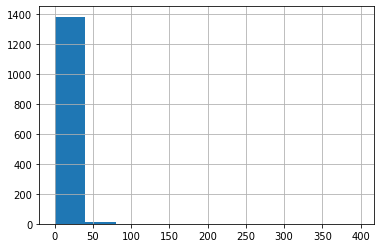

In [21]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count